In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import concatenate as concat
import numpy as np
import tensorflowjs as tfjs
from model.vae.vae_fashionmnist import VariationalAutoEncoderMNIST
from util.experiment import Experiment, load_experiments
from util.plotting import plot_label_clusters
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.manifold import TSNE
from collections import OrderedDict
import copy

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (valid_images, valid_labels) = fashion_mnist.load_data()
valid_images = valid_images.astype("float32") / 255.0
train_images = valid_images.astype("float32") / 255.0
valid_images = tf.expand_dims(valid_images, axis=-1)
train_images = tf.expand_dims(train_images, axis=-1)

class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

2022-06-20 18:14:27.676553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
figsize = 15
fig = plt.figure(figsize=(figsize, 10))
num = 25

def plot_dataset_samples():
    for i in range(num):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        ax.text(0.5, -0.15, str(class_names[valid_labels[i]]) + "/" + str(i), fontsize=10, ha='center', transform=ax.transAxes)
        ax.matshow(valid_images[i].numpy().squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)

<Figure size 1080x720 with 0 Axes>

In [5]:
def print_pretty_dict(d: dict):
    res = ""
    for key, value in d.items():
        res += str(key) + str(value) + "_"
    
    return res[:-1]

In [15]:
run_name = 'branchedClassifier'
hyperparameters = {'latent_dim': 4}
experiments = load_experiments(base_path="experiments/"+run_name, with_params=hyperparameters)


for i, key in enumerate(experiments.keys()):
    experiment = experiments[key]['experiment']

    for key in experiment.history.keys():
        experiment.history[key] = [x.numpy() for x in experiment.history[key]]
        

# Sort experiments by beta value
experiments = OrderedDict(sorted(experiments.items(), key=lambda el: el[1]['params']['beta']))
experiments.keys()

odict_keys(['1305_remain-common-hard-reason', '1333_live-similar-big-child', '1402_die-continue-entire-room'])

## Training

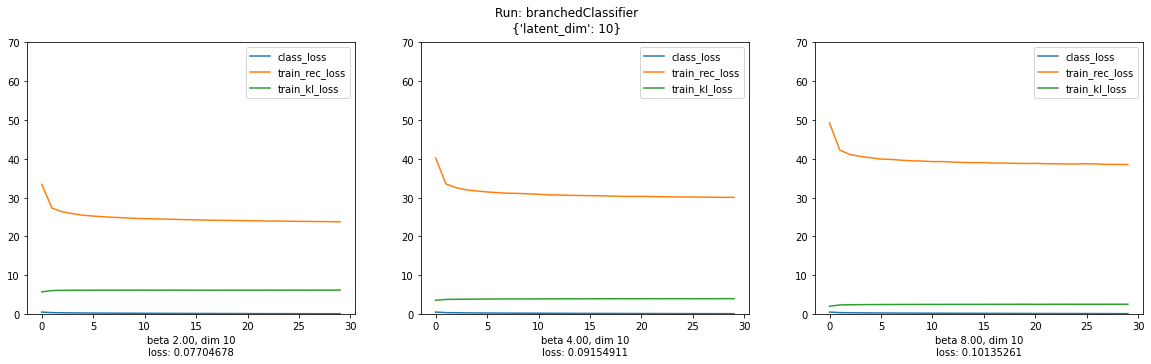

In [10]:
figsize = 20
nrows = 1
ncols = len(experiments.keys())
fig = plt.figure(figsize=(figsize, 5))
fig.suptitle("Run: " + run_name + "\n" + str(hyperparameters))
save_path = ""

for i, key in enumerate(experiments.keys()):
    experiment = experiments[key]['experiment']
    model = experiment.load_model()
    model.compile()
    save_path = experiment.base_path
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])
    
    # Export to vis dir
    #tfjs.converters.save_keras_model(model, 'variational-latent-vis/data/models', input_format='tf_saved_model')
        
    # Plot training loss history
    df_hist = pd.DataFrame(experiment.history)
    loss = df_hist.agg([min]).loc['min',:'train_rec_loss'][0]

    ax = fig.add_subplot(nrows, ncols, i+1)
    #ax.axis('off')
    ax.text(0.5, -0.15, title + "\nloss: " + str(loss), fontsize=10, ha='center', transform=ax.transAxes)
    
    df_hist.loc[:,:'train_kl_loss'].plot(ax=ax, ylim=(0,70))
    
    # Plot model architecture
    tf.keras.utils.plot_model(
        model.encoder.model,
        to_file=os.path.join(experiment.main_dir, 'model_encoder.png'),
        show_shapes=True,
        show_dtype=False,
        show_layer_names=False,
        rankdir='TB',
        expand_nested=True,
        dpi=96,
        layer_range=None,
        show_layer_activations=True
    )
    
fig.savefig(os.path.join(save_path, print_pretty_dict(hyperparameters)+"_train_loss.jpg"), transparent=False)

## Reconstruction Comparison

<Figure size 1080x720 with 0 Axes>

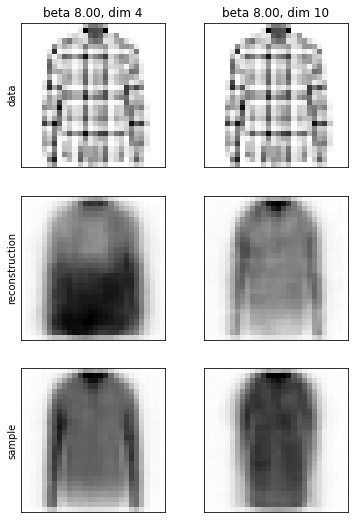

In [14]:
num_experiments = len(experiments.keys())
zm = 3
fig = plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(ncols=num_experiments, nrows=zm, figsize=(3 * num_experiments, zm * 3))

example_data = valid_images[7]
example_data = tf.expand_dims(example_data, axis=0)  # add batch dim

for i, key in enumerate(experiments.keys()):
    # Load data
    experiment = experiments[key]['experiment']
    base_model = experiment.load_model()
    params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
    model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
    model.compile()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])
    
    
    z_mean, z_log_var, _ = model.encode(example_data)
    #qz_x = model.encode_dist(example_data)
    z = model.reparameterize(z_mean, z_log_var)  # qz_x.sample()
    reconstruction = model.decode(z)
    stddev = tf.exp(0.5*z_log_var)
    sampled = model.decoder(keras.backend.random_normal(mean=z_mean, stddev=stddev, shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1])))
    
    # Plot x, x_rec and sample from z
    for axi, (data, label) in enumerate(
        zip(
            [example_data, reconstruction, sampled],
            ["data", "reconstruction", "sample"],
        )
    ):
            axs[axi, i].matshow(
                data.numpy().squeeze()*255, cmap=plt.cm.Greys
            )
            axs[axi, i].axes.get_xaxis().set_ticks([])
            axs[axi, i].axes.get_yaxis().set_ticks([])
            axs[axi, 0].set_ylabel(label)
            axs[0, i].set_title(title)

## Latent space Interpolation

In [442]:
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)


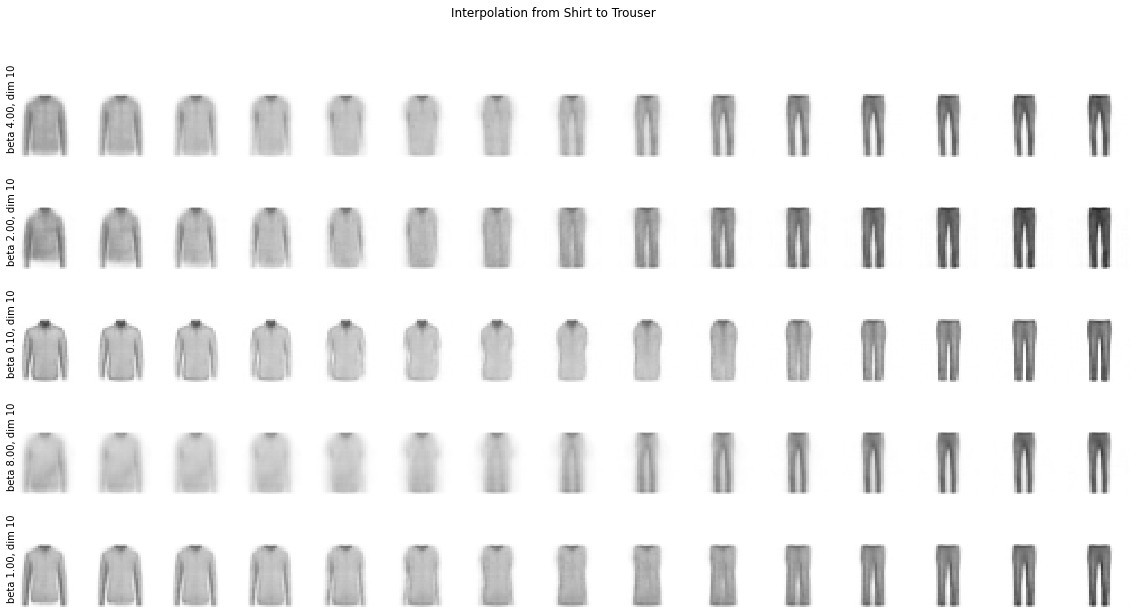

In [443]:
steps = 15
figsize = 20
nrows = len(experiments.keys())
ncols = steps # number of interpolation steps
fig = plt.figure(figsize=(figsize, 10))

start_idx = 7
end_idx = 15
interpolation_start = tf.expand_dims(valid_images[start_idx], axis=0)
interpolation_end = tf.expand_dims(valid_images[end_idx], axis=0)

fig.suptitle("Interpolation from %s to %s" % (class_names[valid_labels[start_idx]], class_names[valid_labels[end_idx]]))

for i, key in enumerate(experiments.keys()):
    experiment = experiments[key]['experiment']
    base_model = experiment.load_model()
    params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
    model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
    model.compile()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])
    
    z_mean_start, z_log_var_start = model.encode(interpolation_start)
    z_mean_end, z_log_var_end = model.encode(interpolation_end)
    
    z_start = model.reparameterize(z_mean_start, z_log_var_start)
    z_end = model.reparameterize(z_mean_end, z_log_var_end)
    
    interpolated_images = interpolate_points(z_start, z_end, steps)
    
    for j, interpolation in enumerate(interpolated_images):
        reconstruction = model.decode(interpolation) 
        
        index = (j+1)+(i*steps)
        ax = fig.add_subplot(nrows, ncols, index)
        if (index-1)%steps == 0 or index == 1:
            ax.text(-0.1, 0.1, title, fontsize=10, ha='left', transform=ax.transAxes, rotation='vertical')
            
        ax.axis('off')
        ax.matshow(reconstruction.numpy().squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)

## Fixing all dimensions but one

In the 𝛽-VAE paper, they seem to use the values of $\beta_{norm}$ ranging between 0.001 and 10 (Fig. 6 from the paper).

They calculate $\beta_{norm}$ as follows:

$\beta_{norm} = \frac{\beta M}{N}$

where $M$ is the size of latent space (e.g. 10) and $N$ is the input size (e.g. 64⋅64⋅1=4096).

In [437]:

## Pre-Training
#exp_name = '1926_turn-special-education-friend' # beta 4, dim 10
#exp_name = '1421_want-walk-free-month' # beta 0.1, dim 10
#exp_name = '1545_could-allow-new-result' # beta 2, dim 10


## Additional Classifier
#exp_name = '2309_let-democratic-blue-power' # beta 1 dim 10
exp_name = '0045_cut-start-happy-hour' # beta 4 
#exp_name = '2357_include-build-federal-program' # beta 2
#exp_name = '2222_sit-continue-other-group' # beta 0.1 
#exp_name = '0133_cut-will-major-team' # beta 8

In [16]:
def traverse_variable(z_mean, z_log_var, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(z_mean-z_log_var, z_mean+z_log_var, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)


In [17]:
def traverse_dim_sep(experiment, model, z_minmax):
    steps = 9
    nrows = experiment.params['latent_dim']
    ncols = steps # number of interpolation steps
    fig = plt.figure(figsize=(2*ncols, 2*nrows))

    example_image = valid_images[0]
    example_image = tf.expand_dims(example_image, axis=0)
    example_label = valid_labels[0]

    title = r'$\beta=%.1f, dim=%d$' % (experiment.params['beta'], experiment.params['latent_dim'])
    fig.suptitle("Run: " + run_name + "\n" + title + "\n" + class_names[example_label], fontsize=18)

    z_mean, z_log_var, _ = model.encode(example_image)
    stddev = tf.exp(z_log_var)
    
    z = model.reparameterize(z_mean, z_log_var)

    traversed = np.linspace(z_mean-tf.abs(z_log_var), z_mean+tf.abs(z_log_var), num=steps)

    for dim in range(0, int(experiment.params['latent_dim'])):
        z_ = copy.deepcopy(z.numpy()) # reference image for this dimension
        for i, image in enumerate(traversed):
            # interpolate in this dimension
            z_[0][dim] = image[0][dim]

            reconstruction = model.decode(z_) 

            index = i+1+dim*steps
            ax = fig.add_subplot(nrows, ncols, index)
            if (index-1)%steps == 0 or index == 1:
                ax.text(-0.3, 0.5, "z" + str(dim), fontsize=10, ha='left', transform=ax.transAxes, rotation='vertical')

            ax.axis('off')
            ax.matshow(reconstruction.numpy().squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
            
    save_path = experiment.main_dir
    fig.savefig(os.path.join(save_path, "_".join(['latent', 'trav', class_names[0], 'b'+str(experiment.params['beta']), 'd'+str(experiment.params['latent_dim'])])+".jpg"), transparent=False)

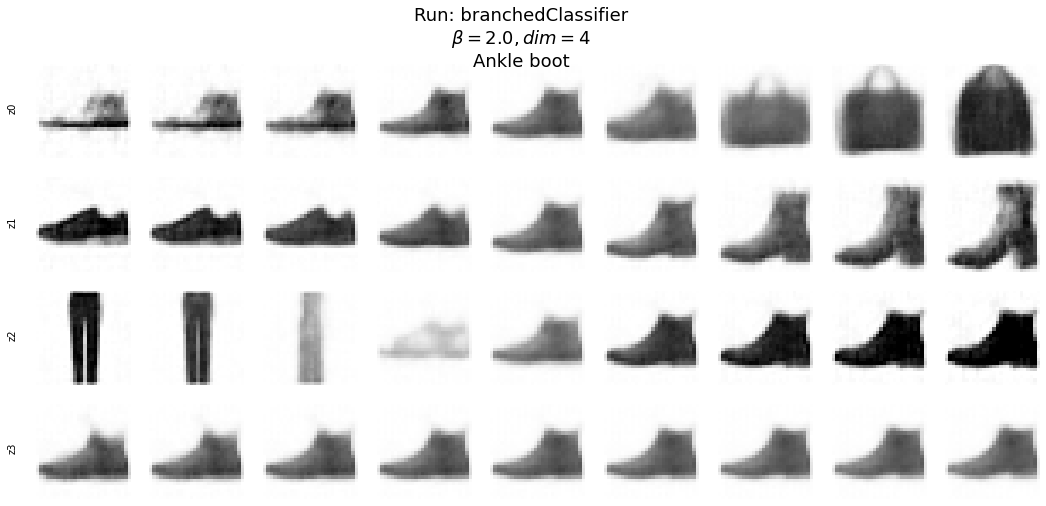

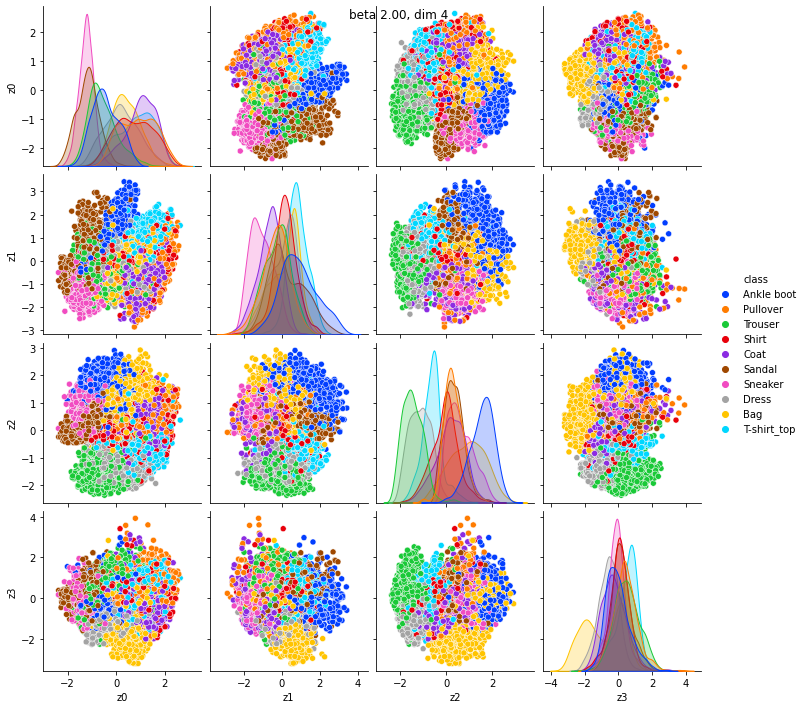

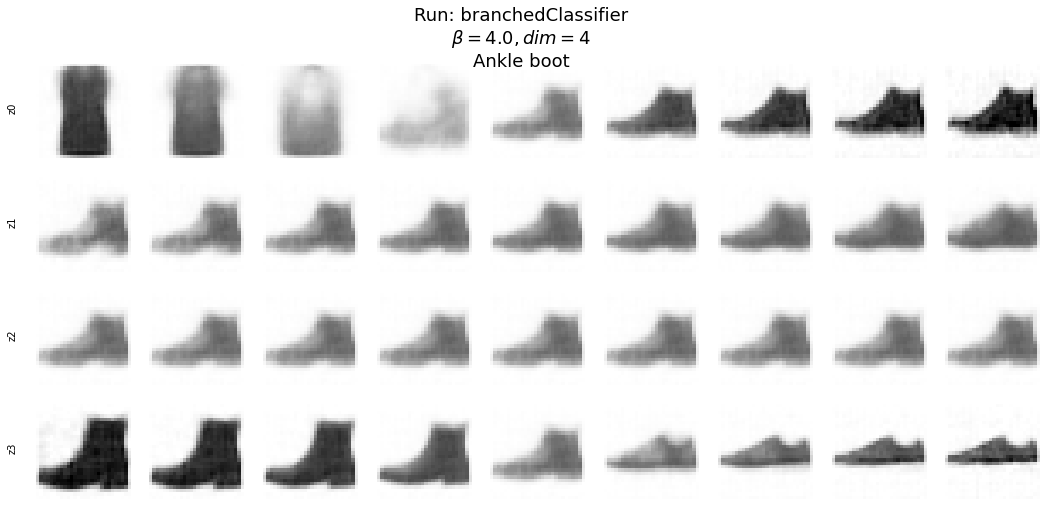

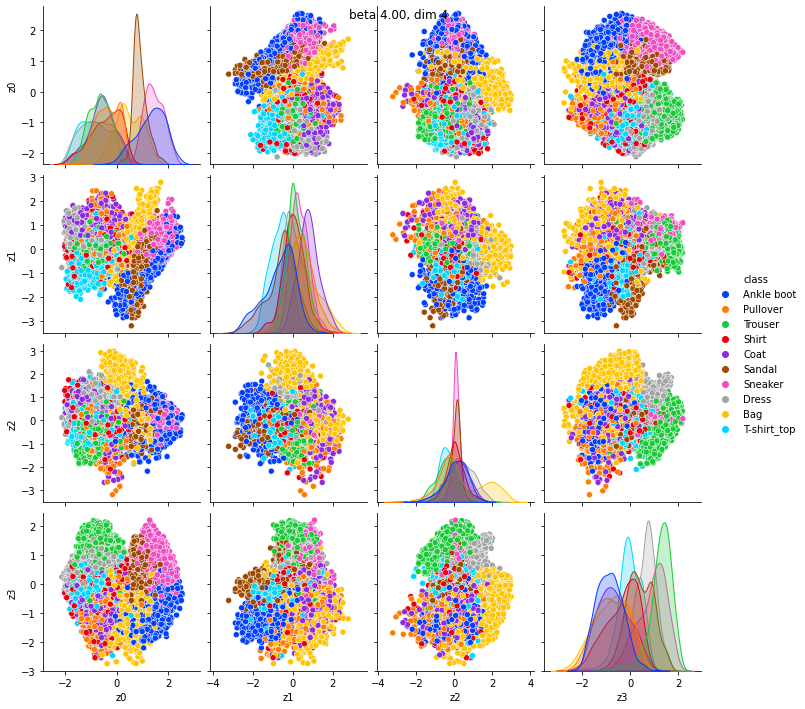

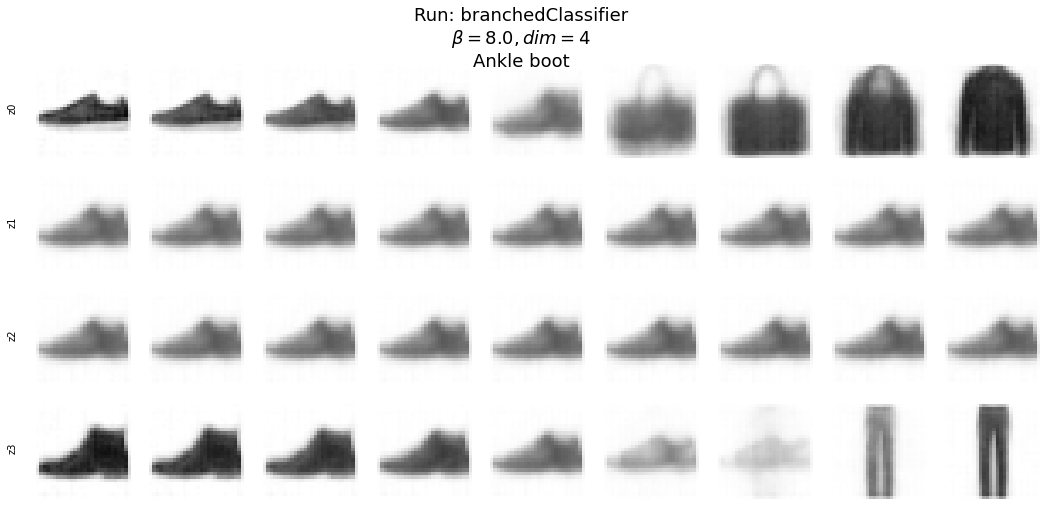

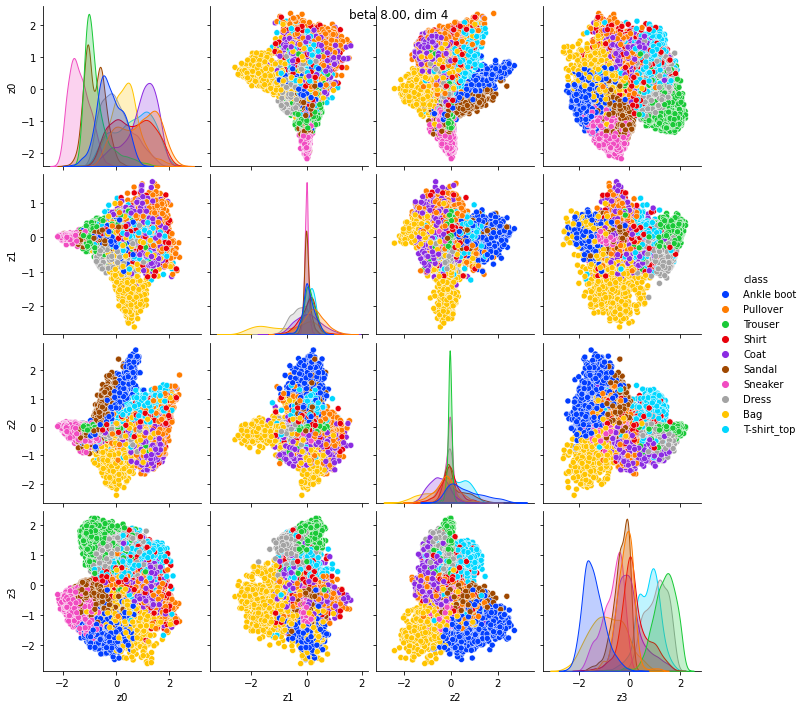

In [18]:
for key in experiments.keys():
    experiment = experiments[key]['experiment']
    base_model = experiment.load_model()
    params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
    model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])

    z_mean, _, _ = model.encoder(valid_images)
    train_labels_decoded = [class_names[i] for i in valid_labels]
    labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
    z_df = pd.DataFrame(z_mean, columns = ['z'+str(i) for i in range(0, z_mean.shape[1])])

    labeled_z_df = pd.concat([labels_df, z_df], axis=1)

    z_minmax = labeled_z_df.loc[:,'z0':].agg([min, max])
    
    traverse_dim_sep(experiment, model, z_minmax)

    pp = sb.pairplot(labeled_z_df, hue="class", palette=sb.color_palette("bright", 10))
    pp.fig.suptitle(title)

    #pp = sb.displot(labeled_z_df.melt('class'), x="value", col="variable", hue="class", kind="kde", palette=sb.color_palette("bright", 10), col_wrap=5, facet_kws=dict(sharey=False))
    #pp.fig.suptitle("Run: " + run_name + "\n" + title)
    
    save_path = experiment.main_dir
    pp.fig.savefig(os.path.join(save_path, "latent_displot.jpg"), transparent=False)
    

## Dimension Visualisation

<Figure size 1440x1080 with 0 Axes>

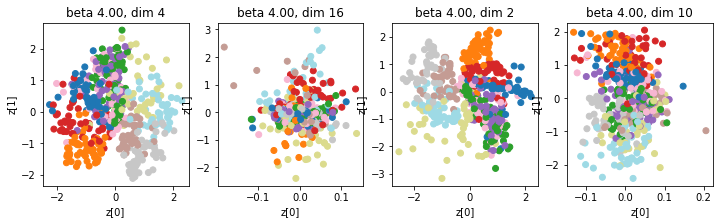

In [359]:
num_experiments = len(experiments.keys())
zm = 1
fig = plt.figure(figsize=(20, 15))
fig, axs = plt.subplots(ncols=num_experiments, nrows=zm, figsize=(3 * num_experiments, zm * 3))

cmap = plt.get_cmap('tab20', len(class_names))
ticks = range(len(class_names))
#cbar = fig.colorbar(ticks=ticks)
#cbar.ax.set_yticklabels(class_names)

for i, key in enumerate(experiments.keys()):
    # Load data
    experiment = experiments[key]['experiment']
    base_model = experiment.load_model()
    params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
    model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])
    
    z_mean, _ = model.encoder(valid_images[:500])
 
    axs[i].scatter(z_mean[:, 0], z_mean[:, 1], c=valid_labels[:500], cmap=cmap)
    axs[i].set_ylabel("z[1]")
    axs[i].set_xlabel("z[0]")
    #axs[i].axes.set_xlim(0, 1)
    #axs[i].axes.set_ylim(0, 1)
    axs[i].set_title(title)
    

Text(0.5, 0.98, 'beta 8.00, dim 2')

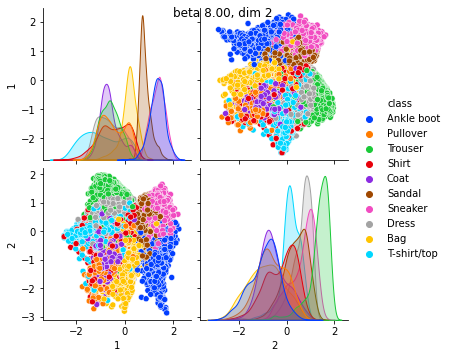

In [99]:
# Pairplot of dimensions
experiment = experiments['2019_will-fall-general-story']['experiment']
base_model = experiment.load_model()
params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])

z_mean, _ = model.encoder(valid_images)
train_labels_decoded = [class_names[i] for i in valid_labels]
labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
z_df = pd.DataFrame(z_mean, columns = [str(i) for i in range(1, z_mean.shape[1] + 1)])

labeled_z_df = pd.concat([labels_df, z_df], axis=1)
pp = sb.pairplot(labeled_z_df, hue="class", palette=sb.color_palette("bright", 10))
pp.fig.suptitle(title)

In [ ]:
for key in experiments.keys():
    # key = '09-05-2022_2016_feel-major-eye-guy'
    experiment = experiments[key]['experiment']
    print("History", min(experiment.history['train_loss']))
    model = experiment.load_model()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])

    #plot_label_clusters(model, train_images, train_labels, experiment.vis_dir, title=title, show=True)
    


    # Pairplot of dimensions
    _, _, z = model.encoder(valid_images)
    train_labels_decoded = [class_names[i] for i in valid_labels]
    labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
    z_df = pd.DataFrame(z, columns = [str(i) for i in range(1, z.shape[1] + 1)])

    labeled_z_df = pd.concat([labels_df, z_df], axis=1)
    pp = sb.pairplot(labeled_z_df, hue="class", palette=sb.color_palette("bright", 10))
    pp.fig.suptitle(title)
    
    # TSNE
    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(z_df)
    tsne_result.shape
    
    # Plot the result of our TSNE with the label color coded
    # A lot of the stuff here is about making the plot look pretty and not TSNE
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels_df})
    fig, ax = plt.subplots(1)
    sb.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=40, alpha=0.6)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)